In [36]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import torch

In [10]:
# fetch dataset
student_performance = fetch_ucirepo(id=320)

# data (as pandas dataframes)
X = student_performance.data.features
y = student_performance.data.targets

X

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,4
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,2,3,3,6
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,1,1,5,0
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,1,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,yes,yes,no,5,4,2,1,2,5,4
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,yes,yes,no,4,3,4,1,1,1,4
646,MS,F,18,U,GT3,T,1,1,other,other,...,yes,no,no,1,1,1,1,1,5,6
647,MS,M,17,U,LE3,T,3,1,services,services,...,yes,yes,no,2,4,5,3,4,2,6


# Clustering
## K-Means + PCA

Selected 11 numerical columns: ['age', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


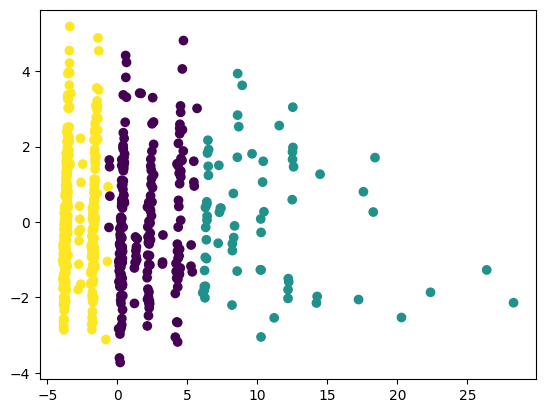

In [37]:
numericalColumns = X.select_dtypes(exclude=['object', 'bool']).columns
numericalColumns = list(numericalColumns)
numericalColumns.remove('Medu')
numericalColumns.remove('Fedu')
print(f"Selected {len(numericalColumns)} numerical columns: {numericalColumns}")

# k-means
kmeans = KMeans(n_clusters=3, init='k-means++')
kmeans.fit(X[numericalColumns])

# use PCA to reduce dimensions to 2
pca = PCA(n_components=2).fit(X[numericalColumns])
datapoint = pca.transform(X[numericalColumns])

# plot
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=kmeans.labels_)
plt.show()

## Auto-Encoders

In [38]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, inputSize : int, embeddingSize : int, intermediateLayers : list[int]) -> None:
        super().__init__()
        self.inputSize = inputSize
        self.embeddingSize = embeddingSize
        self.intermediateLayers = intermediateLayers
        self.encoder = torch.nn.Sequential()
        self.decoder = torch.nn.Sequential()
        
        if (len(intermediateLayers) == 0):
            self.encoder.add_module(f"encoder_0", torch.nn.Linear(self.inputSize, self.embeddingSize))
            self.decoder.add_module(f"decoder_0", torch.nn.Linear(self.embeddingSize, self.inputSize))
            return

        # encoder
        self.encoder.add_module(f"encoder_0", torch.nn.Linear(self.inputSize, self.intermediateLayers[0]))
        self.encoder.add_module(f"encoder_activation_0", torch.nn.ReLU())
        for i in range(1, len(self.intermediateLayers)):
            self.encoder.add_module(f"encoder_{i}", torch.nn.Linear(self.intermediateLayers[i-1], self.intermediateLayers[i]))
            self.encoder.add_module(f"encoder_activation_{i}", torch.nn.ReLU())
        self.encoder.add_module(f"encoder_{len(self.intermediateLayers)}", torch.nn.Linear(self.intermediateLayers[-1], self.embeddingSize))

        # decoder
        self.decoder.add_module(f"decoder_0", torch.nn.Linear(self.embeddingSize, self.intermediateLayers[0]))
        self.decoder.add_module(f"decoder_activation_0", torch.nn.ReLU())
        for i in range(1, len(self.intermediateLayers)):
            self.decoder.add_module(f"decoder_{i}", torch.nn.Linear(self.intermediateLayers[i-1], self.intermediateLayers[i]))
            self.decoder.add_module(f"decoder_activation_{i}", torch.nn.ReLU())
        self.decoder.add_module(f"decoder_{len(self.intermediateLayers)}", torch.nn.Linear(self.intermediateLayers[-1], self.inputSize))
        
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        h = x
        x = self.decoder(x)
        return x, h

Epoch 0: 24.002454
Epoch 10: 2.899601
Epoch 20: 1.004966
Epoch 30: 0.945703
Epoch 40: 0.941211


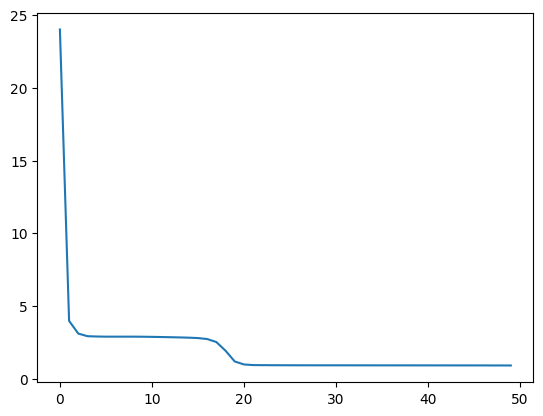

In [64]:
model = AutoEncoder(len(numericalColumns), 2, [16, 8])
epochs = 50
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

trainLoss = []
for epoch in range(epochs):
    # divide into batches
    runningLoss = 0
    for i in range(0, len(X[numericalColumns]), 32):
        optimizer.zero_grad()
        output, _ = model(torch.tensor(X[numericalColumns].iloc[i:i+32].values, dtype=torch.float))
        loss = torch.nn.functional.mse_loss(output, torch.tensor(X[numericalColumns].iloc[i:i+32].values, dtype=torch.float))
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    trainLoss.append(runningLoss / (len(X[numericalColumns]) / 32))
    if (epoch % 10 == 0):
        print(f"Epoch {epoch}: {trainLoss[-1]:3f}")

# plot
plt.plot(trainLoss)
plt.show()

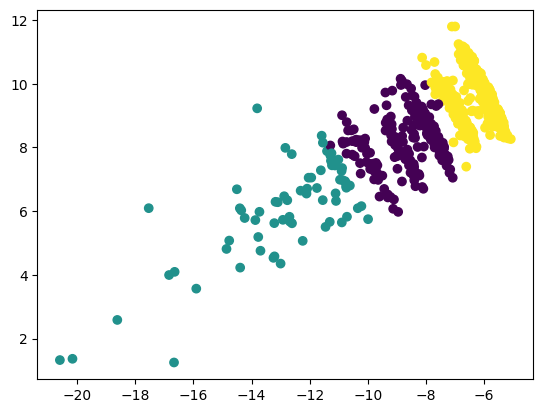

In [68]:
with torch.no_grad():
    embeddings = model.encoder(torch.tensor(X[numericalColumns].values, dtype=torch.float)).detach().numpy()
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=kmeans.labels_)
plt.show()